# EDA de ventas (Puntos 2 a 10) para 'train.csv'


## Paso 1 Importaciones y configuración


In [5]:
# ============================================================
# Estructura esperada: date,store,item,sales
# ------------------------------------------------------------
# Si necesitas instalar dependencias en un nuevo entorno:
# !pip install pandas numpy matplotlib seaborn statsmodels plotly
# ============================================================

import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.tseries.frequencies import to_offset
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set(style="whitegrid", context="notebook")
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

# Obtener la ruta del proyecto (directorio padre de notebooks/)
PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
DATA_PATH = os.path.join(PROJECT_ROOT, "data", "raw", "train.csv")

In [6]:
# Utilidades
def print_section(title: str):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))

def check_daily_frequency(group_df: pd.DataFrame, date_col="date") -> dict:
    """Verifica consistencia diaria dentro de un grupo (store-item)."""
    g = group_df.sort_values(date_col)
    if g.shape[0] <= 1:
        return {"expected_len": 1, "actual_len": 1, "missing_days": 0, "is_daily": True}
    rng = pd.date_range(g[date_col].min(), g[date_col].max(), freq="D")
    present = pd.Index(g[date_col].dt.normalize().unique())
    missing = rng.difference(present)
    return {
        "expected_len": len(rng),
        "actual_len": len(present),
        "missing_days": len(missing),
        "is_daily": len(missing) == 0
    }

def add_time_features(df: pd.DataFrame, date_col="date") -> pd.DataFrame:
    df = df.copy()
    df["year"] = df[date_col].dt.year
    df["month"] = df[date_col].dt.month
    df["day"] = df[date_col].dt.day
    df["week"] = df[date_col].dt.isocalendar().week.astype(int)
    df["dow"] = df[date_col].dt.dayofweek  # 0=Lunes ... 6=Domingo
    df["month_name"] = df[date_col].dt.month_name()
    df["dow_name"] = df[date_col].dt.day_name()
    df["is_weekend"] = df["dow"].isin([5, 6]).astype(int)
    return df

def plot_time_series(series: pd.Series, title="", ylabel="Sales"):
    plt.figure(figsize=(12,4))
    plt.plot(series.index, series.values)
    plt.title(title)
    plt.xlabel("Fecha")
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def plot_bars(s: pd.Series, title="", xlabel="", ylabel=""):
    plt.figure(figsize=(10,4))
    s.plot(kind="bar")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def plot_heatmap(df_pivot: pd.DataFrame, title="",xlabel=""):
    plt.figure(figsize=(12,6))
    
    # Si el índice es datetime, formatearlo
    df_plot = df_pivot.copy()
    if isinstance(df_plot.index, pd.DatetimeIndex):
        df_plot.index = df_plot.index.strftime('%Y-%m')
    
    sns.heatmap(df_plot, annot=False, fmt="g", cmap="rocket_r")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Date")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_acf_pacf(series: pd.Series, lags=30, title_prefix=""):
    fig, ax = plt.subplots(2,1, figsize=(10,6))
    plot_acf(series.dropna(), lags=lags, ax=fig.axes[0])
    fig.axes[0].set_title(f"{title_prefix} - ACF (hasta {lags} rezagos)")
    plot_pacf(series.dropna(), lags=lags, ax=fig.axes[1], method="ywm")
    fig.axes[1].set_title(f"{title_prefix} - PACF (hasta {lags} rezagos)")
    fig.tight_layout()
    plt.show()

## Paso 2 — Comprensión inicial del dataset


In [7]:

# a) Cargar dataset y primeras filas
df = pd.read_csv(
    DATA_PATH,
    parse_dates=["date"],
    dtype={"store": "int32", "item": "int32", "sales": "int32"}
)
print("Primeras 5 filas:")
display(df.head())

Primeras 5 filas:


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [8]:
# b) Tamaño del dataset
print("\nTamaño del dataset (filas, columnas):", df.shape)


Tamaño del dataset (filas, columnas): (913000, 4)


In [9]:

# c) Descripción breve de columnas (impresión informativa)
col_desc = {
    "date": "Fecha de la venta (diaria).",
    "store": "Identificador de la sucursal.",
    "item": "Identificador del producto.",
    "sales": "Unidades vendidas ese día (entero)."
}
print("\nDescripción de columnas:")
for k, v in col_desc.items():
    print(f" - {k}: {v}")


Descripción de columnas:
 - date: Fecha de la venta (diaria).
 - store: Identificador de la sucursal.
 - item: Identificador del producto.
 - sales: Unidades vendidas ese día (entero).


In [10]:
# d) Rango temporal
print("\nRango temporal:")
print(" - Fecha mínima:", df["date"].min())
print(" - Fecha máxima:", df["date"].max())


Rango temporal:
 - Fecha mínima: 2013-01-01 00:00:00
 - Fecha máxima: 2017-12-31 00:00:00


## Paso 3 — Validación de estructura de datos


In [11]:

# a) Tipos de datos
print("Tipos de datos:")
print(df.dtypes)

Tipos de datos:
date     datetime64[ns]
store             int32
item              int32
sales             int32
dtype: object


In [12]:
# b) Confirmar que 'date' es datetime y sin nulos
df["date"] = pd.to_datetime(df["date"], errors="coerce")
n_null_date = df["date"].isna().sum()
print("\nNulos en 'date':", int(n_null_date))
assert n_null_date == 0, "Existen fechas no parseables; revisar datos."


Nulos en 'date': 0


In [13]:
# c) Validar frecuencia temporal (diaria) por (store, item)
freq_checks = (
    df.groupby(["store", "item"])
      .apply(lambda g: pd.Series(check_daily_frequency(g, "date")))
      .reset_index()
)
print("\nResumen de consistencia diaria por (store, item):")
display(freq_checks.head())
prop_diarias = (freq_checks["is_daily"].mean() * 100).round(2)
print(f"Porcentaje de series (store-item) con frecuencia diaria consistente: {prop_diarias}%")


Resumen de consistencia diaria por (store, item):


,store,item,expected_len,actual_len,missing_days,is_daily
0,1,1,1826,1826,0,True
1,1,2,1826,1826,0,True
2,1,3,1826,1826,0,True
3,1,4,1826,1826,0,True
4,1,5,1826,1826,0,True


Porcentaje de series (store-item) con frecuencia diaria consistente: 100.0%


## Paso 4 — Valores faltantes y duplicados


In [14]:

# a) Nulos por columna
nulls = df.isna().sum().to_frame("n_nulos")
nulls["pct_%"] = (nulls["n_nulos"] / len(df) * 100).round(4)
print("Valores nulos por columna:")
display(nulls)

Valores nulos por columna:


,n_nulos,pct_%
date,0,0.00
store,0,0.00
item,0,0.00
sales,0,0.00


In [15]:
# b) Estrategias (solo se imprime guía; el tratamiento dependerá del caso)
print("\nEstrategia sugerida:")
print("- Si hubiera nulos en 'sales' y son pocos, considerar imputar con 0 o mediana por (store,item,dow).")
print("- Si hubiera nulos en 'date', revisar y corregir origen (no imputar fechas).")
print("- Si hubiera nulos en 'store' o 'item', validar con negocio antes de eliminar.")


Estrategia sugerida:
- Si hubiera nulos en 'sales' y son pocos, considerar imputar con 0 o mediana por (store,item,dow).
- Si hubiera nulos en 'date', revisar y corregir origen (no imputar fechas).
- Si hubiera nulos en 'store' o 'item', validar con negocio antes de eliminar.


In [16]:
# c) Duplicados
dup_count = df.duplicated(subset=["date","store","item"]).sum()
print("\nRegistros duplicados exactos por (date, store, item):", int(dup_count))
if dup_count > 0:
    df = df.drop_duplicates(subset=["date","store","item"])
    print("Duplicados removidos. Nuevo tamaño:", df.shape)



Registros duplicados exactos por (date, store, item): 0


## Paso 5 — Análisis descriptivo general


In [17]:

# a) Métricas básicas de ventas
print("Estadísticos básicos de 'sales':")
display(df["sales"].describe().to_frame())


Estadísticos básicos de 'sales':


,sales
count,"913,000.00"
mean,52.25
std,28.80
min,0.00
25%,30.00
50%,47.00
75%,70.00
max,231.00


In [18]:
# b) Distribuciones por Producto, Sucursal y Periodos de tiempo
df = add_time_features(df, "date")

sales_by_item = df.groupby("item")["sales"].agg(["count","sum","mean","median","std"]).sort_values("sum", ascending=False)
sales_by_store = df.groupby("store")["sales"].agg(["count","sum","mean","median","std"]).sort_values("sum", ascending=False)

print("\nDistribución por Producto:")
display(sales_by_item.head(10))

print("\nDistribución por Sucursal:")
display(sales_by_store.head(10))

sales_by_year  = df.groupby("year")["sales"].sum()
sales_by_month = df.groupby(["year","month"])["sales"].sum()
sales_by_dow   = df.groupby("dow")["sales"].mean()

print("\nVentas totales por año:")
display(sales_by_year.to_frame("sales"))

print("\nVentas totales por año-mes:")
display(sales_by_month.to_frame("sales").head(12))

print("\nVentas promedio por día de la semana (0=Lun ... 6=Dom):")
display(sales_by_dow.to_frame("avg_sales_by_dow"))


Distribución por Producto:


,count,sum,mean,median,std
item,,,,,
15,18260,1607442,88.03,85.00,29.52
28,18260,1604713,87.88,85.00,29.50
13,18260,1539621,84.32,81.00,28.31
18,18260,1538876,84.28,81.00,28.43
25,18260,1473334,80.69,78.00,27.24
45,18260,1471467,80.58,78.00,27.32
38,18260,1470330,80.52,77.00,27.14
22,18260,1469971,80.50,78.00,27.12
36,18260,1406548,77.03,74.00,26.07



Distribución por Sucursal:


,count,sum,mean,median,std
store,,,,,
2,91300,6120128,67.03,62.00,33.60
8,91300,5856169,64.14,60.00,32.23
3,91300,5435144,59.53,55.00,29.97
10,91300,5360158,58.71,54.00,29.55
9,91300,5025976,55.05,51.00,27.83
4,91300,5012639,54.90,51.00,27.73
1,91300,4315603,47.27,44.00,24.01
5,91300,3631016,39.77,37.00,20.37
6,91300,3627670,39.73,37.00,20.31



Ventas totales por año:


,sales
year,
2013,7941243
2014,9135482
2015,9536887
2016,10357160
2017,10733740



Ventas totales por año-mes:


sales
year month        
2013 1      454904
     2      459417
     3      617382
     4      682274
     5      763242
     6      795597
     7      855922
     8      766761
     9      689907
     10     656587
     11     692643
     12     506607


Ventas promedio por día de la semana (0=Lun ... 6=Dom):


,avg_sales_by_dow
dow,
0,41.43
1,48.23
2,48.37
3,51.72
4,55.16
5,58.66
6,62.14


## Paso 6 — Exploración temporal (gráficos)


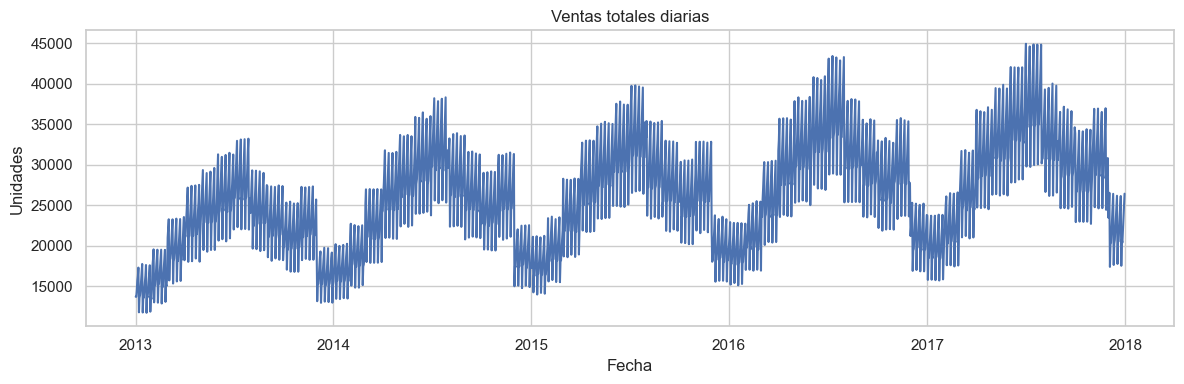

In [19]:

total_daily = df.groupby("date")["sales"].sum().sort_index()
plot_time_series(total_daily, "Ventas totales diarias", "Unidades")

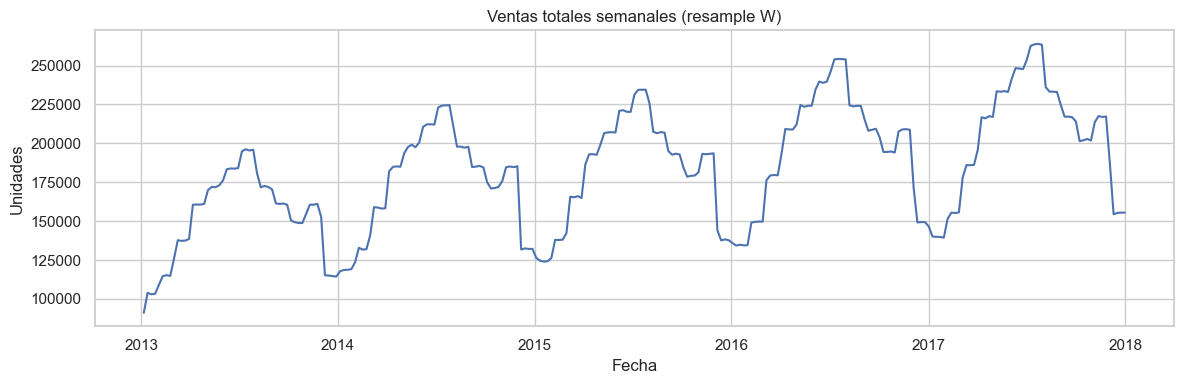

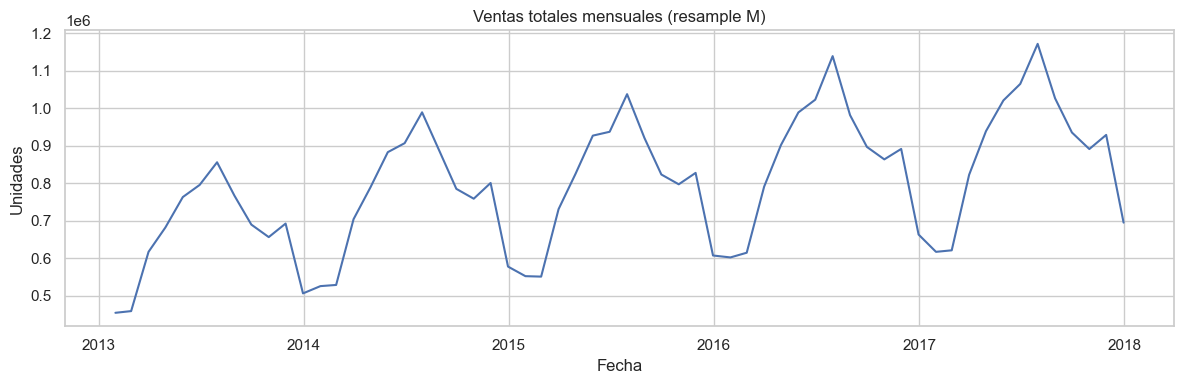

In [20]:
# Resúmenes temporales
plot_time_series(total_daily.resample("W").sum(), "Ventas totales semanales (resample W)", "Unidades")
plot_time_series(total_daily.resample("M").sum(), "Ventas totales mensuales (resample M)", "Unidades")


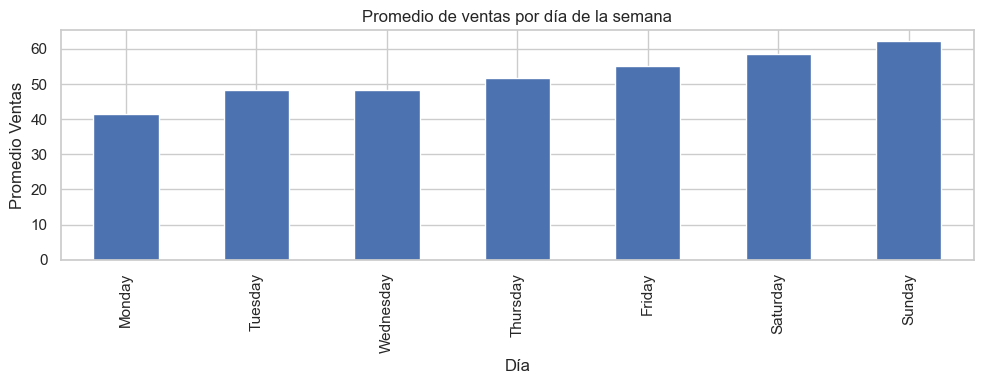

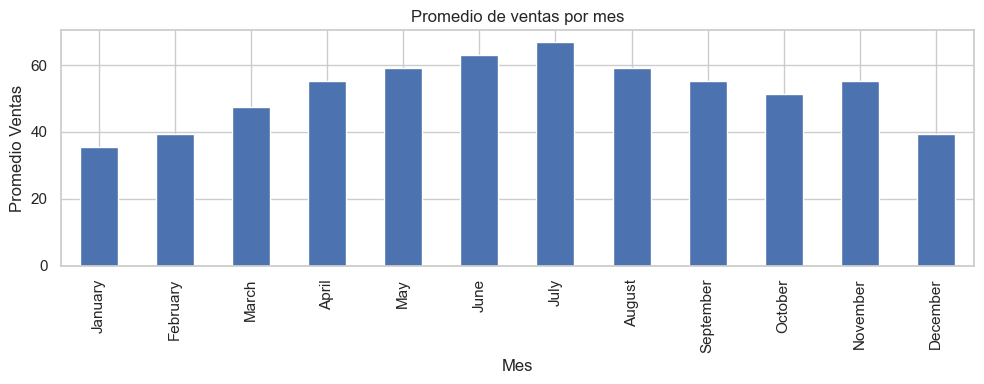

In [21]:
# Patrones por día de la semana y mes
plot_bars(df.groupby("dow_name")["sales"].mean().reindex(
    ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
), "Promedio de ventas por día de la semana", "Día", "Promedio Ventas")

plot_bars(df.groupby("month_name")["sales"].mean().reindex(
    [m for m in pd.date_range("2000-01-01","2000-12-01", freq="MS").month_name()]
), "Promedio de ventas por mes", "Mes", "Promedio Ventas")

## Paso 7 — Comparativas entre sucursales y productos


In [22]:

# a) Productos más y menos vendidos
top_items = sales_by_item["sum"].head(10)
low_items = sales_by_item["sum"].tail(10)
print("Top 10 productos más vendidos (por unidades):")
display(top_items.to_frame("total_sales"))
print("\nBottom 10 productos menos vendidos (por unidades):")
display(low_items.to_frame("total_sales"))

Top 10 productos más vendidos (por unidades):


,total_sales
item,
15,1607442
28,1604713
13,1539621
18,1538876
25,1473334
45,1471467
38,1470330
22,1469971
36,1406548



Bottom 10 productos menos vendidos (por unidades):


,total_sales
item,
37,534258
40,534094
34,469935
16,468480
27,402628
4,401907
47,401781
41,401759
1,401384


In [23]:
# b) Desempeño por sucursal
top_stores = sales_by_store["sum"].head(10)
print("\nTop 10 sucursales por ventas totales:")
display(top_stores.to_frame("total_sales"))


Top 10 sucursales por ventas totales:


,total_sales
store,
2,6120128
8,5856169
3,5435144
10,5360158
9,5025976
4,5012639
1,4315603
5,3631016
6,3627670


In [24]:
# c) Detección de outliers por (store,item) en ventas diarias usando IQR
def detect_outliers_iqr(group):
    q1, q3 = group["sales"].quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - 1.5*iqr, q3 + 1.5*iqr
    out = group[(group["sales"] < lo) | (group["sales"] > hi)].copy()
    out["lo"], out["hi"] = lo, hi
    return out

outliers = (
    df.sort_values("date")
      .groupby(["store","item"], group_keys=False)
      .apply(detect_outliers_iqr)
)
print("\nPosibles outliers (primeras 15 filas):")
display(outliers.head(15))


Posibles outliers (primeras 15 filas):


,date,store,item,sales,year,month,day,week,dow,month_name,dow_name,is_weekend,lo,hi
159,2013-06-09,1,1,38,2013,6,9,23,6,June,Sunday,1,1.50,37.50
886,2015-06-06,1,1,43,2015,6,6,23,5,June,Saturday,1,1.50,37.50
914,2015-07-04,1,1,40,2015,7,4,27,5,July,Saturday,1,1.50,37.50
926,2015-07-16,1,1,41,2015,7,16,29,3,July,Thursday,0,1.50,37.50
928,2015-07-18,1,1,38,2015,7,18,29,5,July,Saturday,1,1.50,37.50
929,2015-07-19,1,1,38,2015,7,19,29,6,July,Sunday,1,1.50,37.50
936,2015-07-26,1,1,38,2015,7,26,30,6,July,Sunday,1,1.50,37.50
991,2015-09-19,1,1,40,2015,9,19,38,5,September,Saturday,1,1.50,37.50
1230,2016-05-15,1,1,39,2016,5,15,19,6,May,Sunday,1,1.50,37.50
1249,2016-06-03,1,1,38,2016,6,3,22,4,June,Friday,0,1.50,37.50


## Paso 8 — Visualizaciones clave


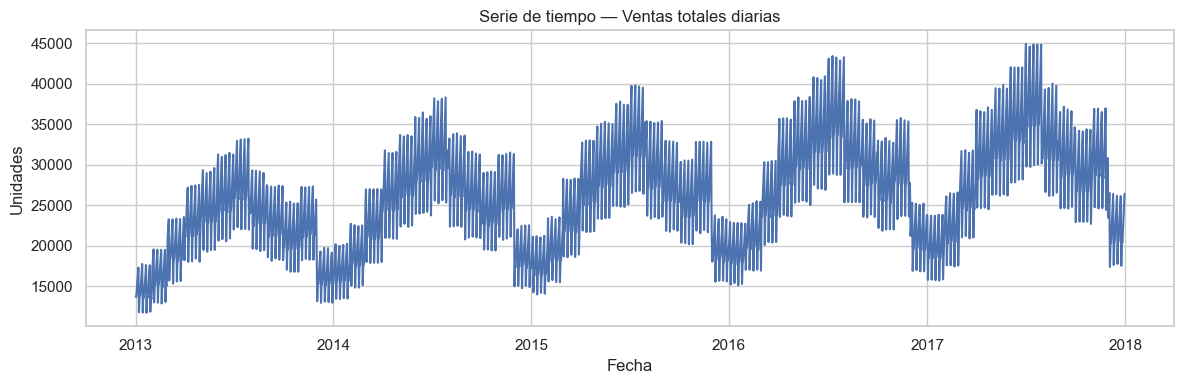

In [25]:
# a) Serie de tiempo de ventas totales (ya graficada en Paso 6)
plot_time_series(total_daily, "Serie de tiempo — Ventas totales diarias", "Unidades")

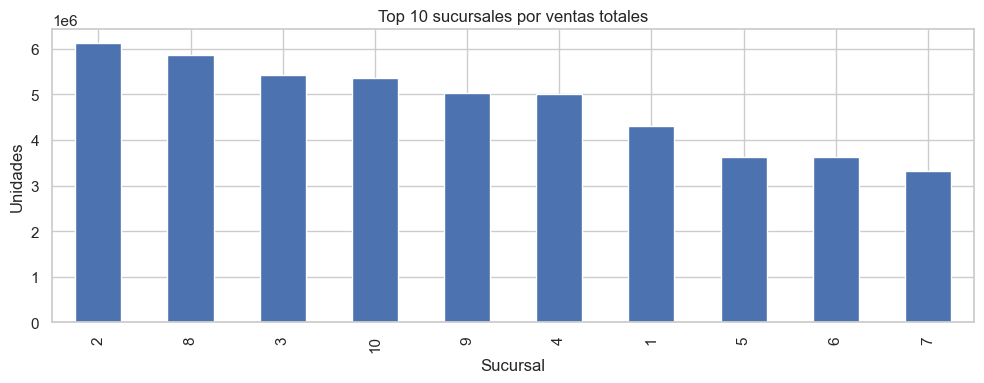

In [26]:
# b) Barras por sucursal
plot_bars(top_stores, "Top 10 sucursales por ventas totales", "Sucursal", "Unidades")

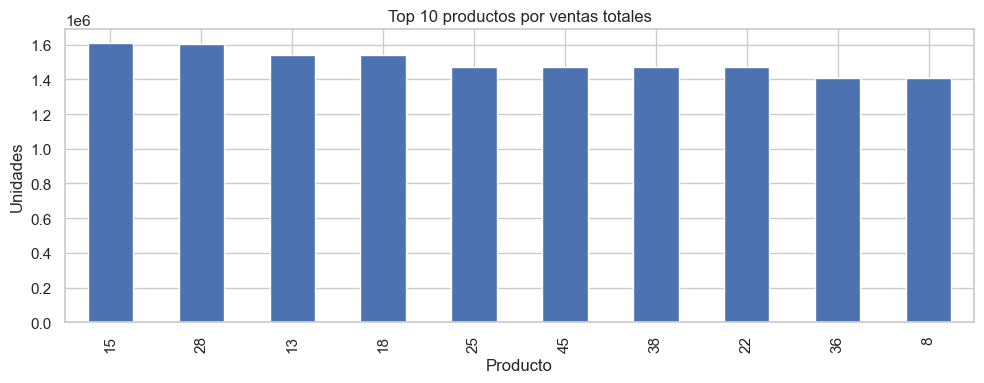

In [27]:

# c) Barras por producto
plot_bars(top_items, "Top 10 productos por ventas totales", "Producto", "Unidades")

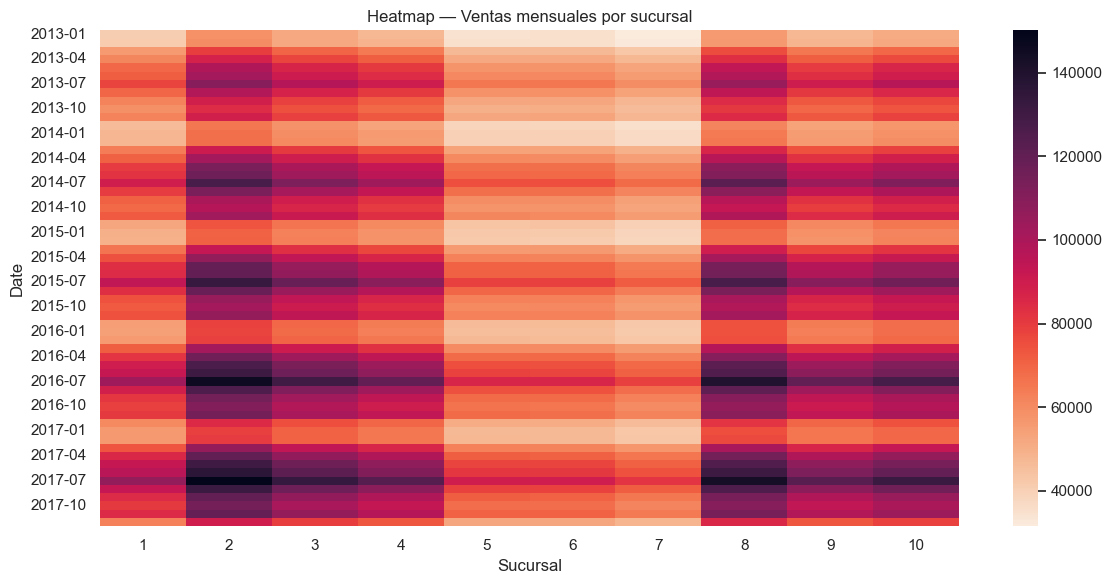

In [28]:
# d) Heatmaps (ejemplos)
#   - Ventas mensuales por sucursal
monthly_store = df.set_index("date").groupby("store")["sales"].resample("M").sum().reset_index()
pivot_store = monthly_store.pivot_table(index="date", columns="store", values="sales", fill_value=0)
plot_heatmap(pivot_store, "Heatmap — Ventas mensuales por sucursal", xlabel="Sucursal")

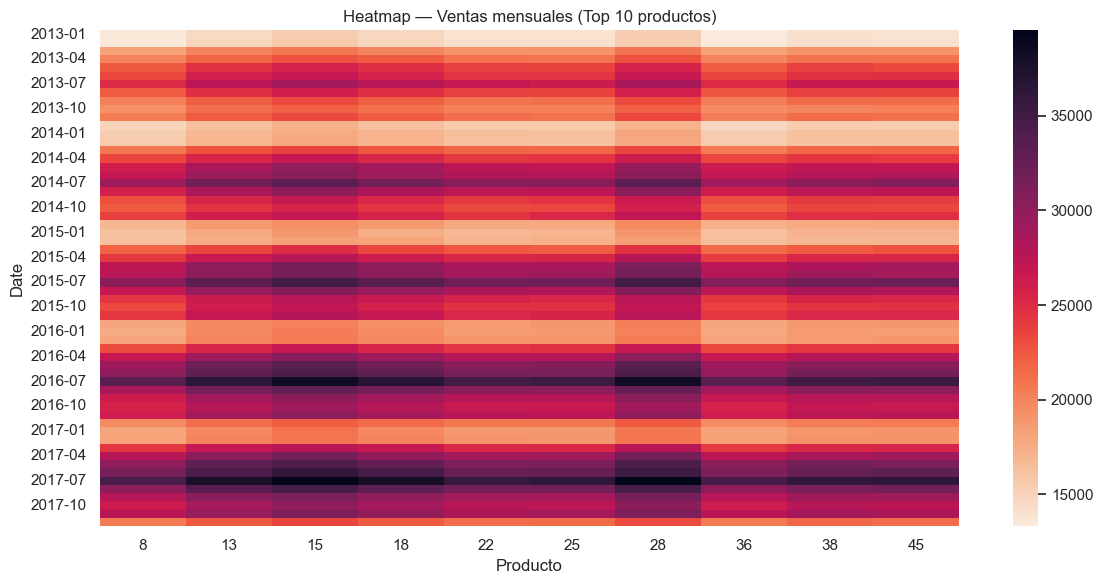

In [29]:
#   - Ventas mensuales por producto (si hay muchos items, filtra top N)
topN_items = list(top_items.index[:10])
monthly_item = (
    df[df["item"].isin(topN_items)]
    .set_index("date")
    .groupby("item")["sales"]
    .resample("M").sum().reset_index()
)
pivot_item = monthly_item.pivot_table(index="date", columns="item", values="sales", fill_value=0)
plot_heatmap(pivot_item, "Heatmap — Ventas mensuales (Top 10 productos)", xlabel="Producto")


## Paso 9 — ACF y PACF por series


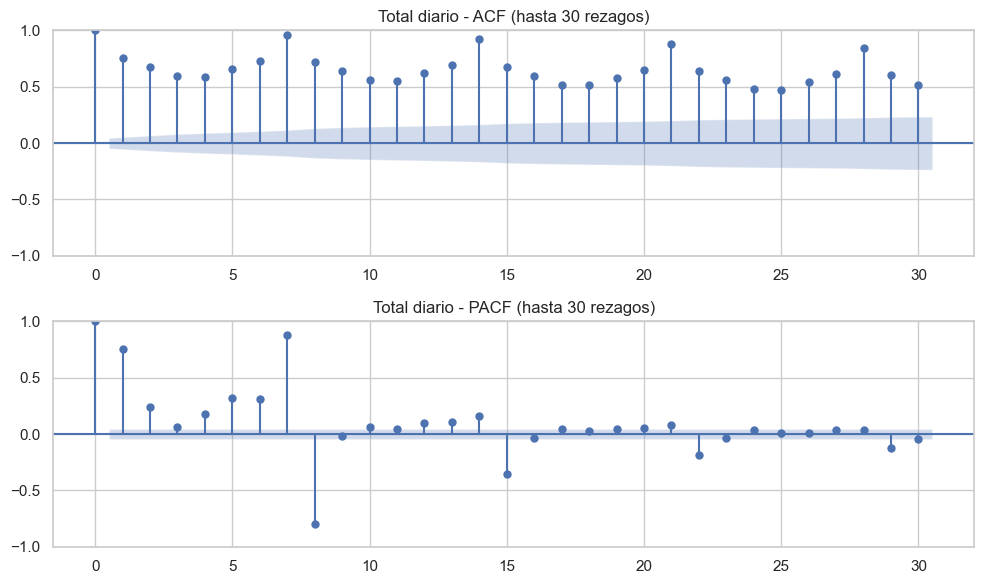

In [30]:
# a) Total
plot_acf_pacf(total_daily, lags=30, title_prefix="Total diario")

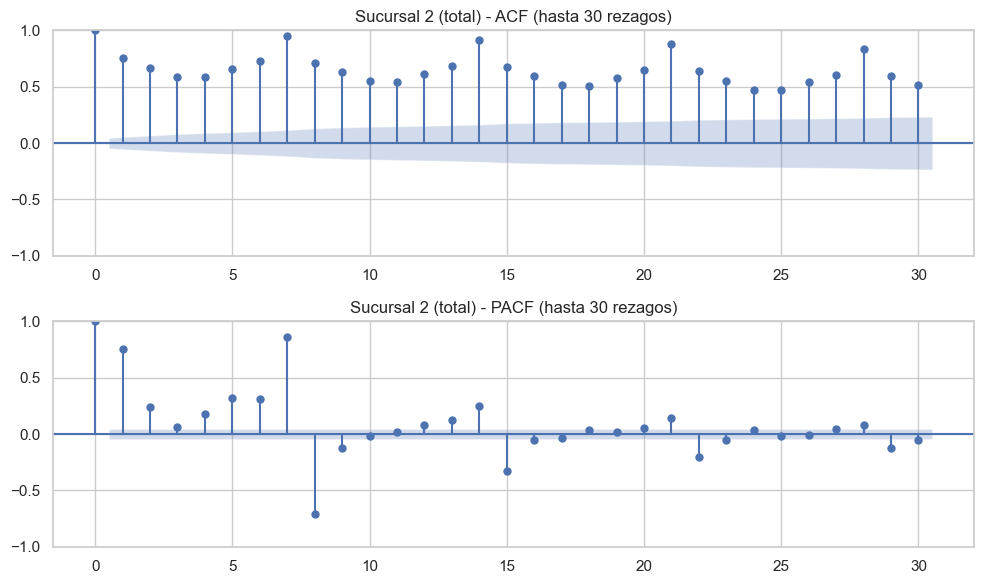

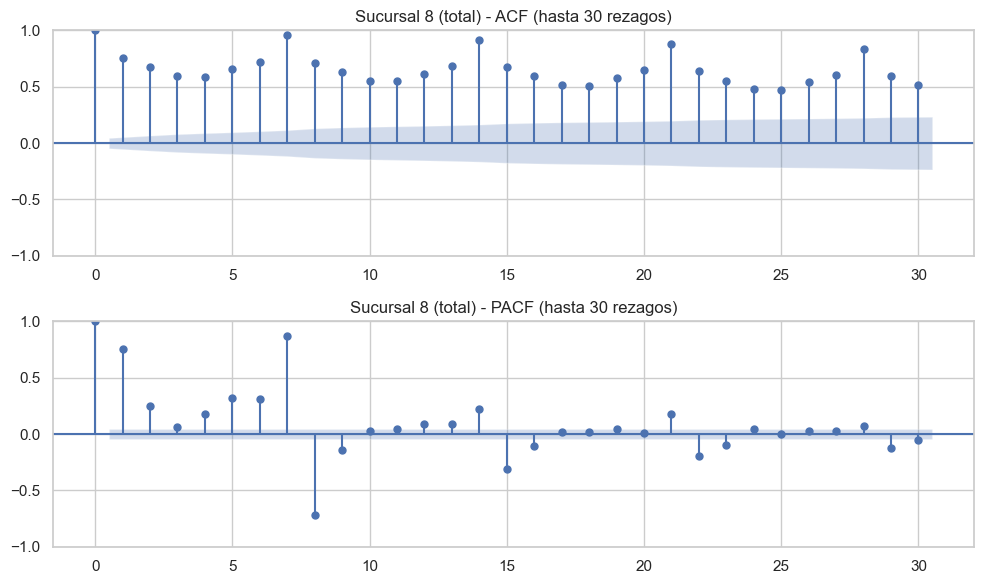

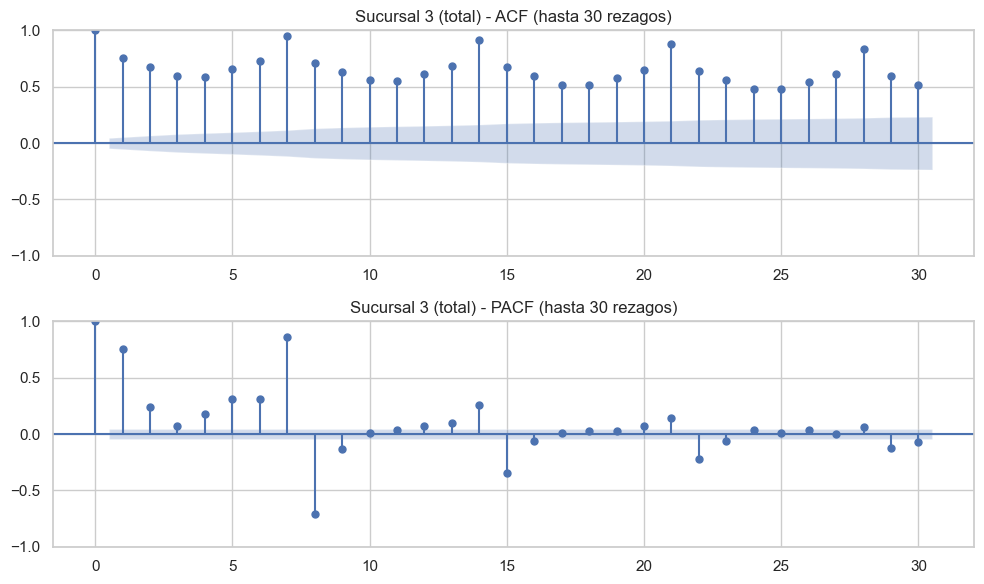

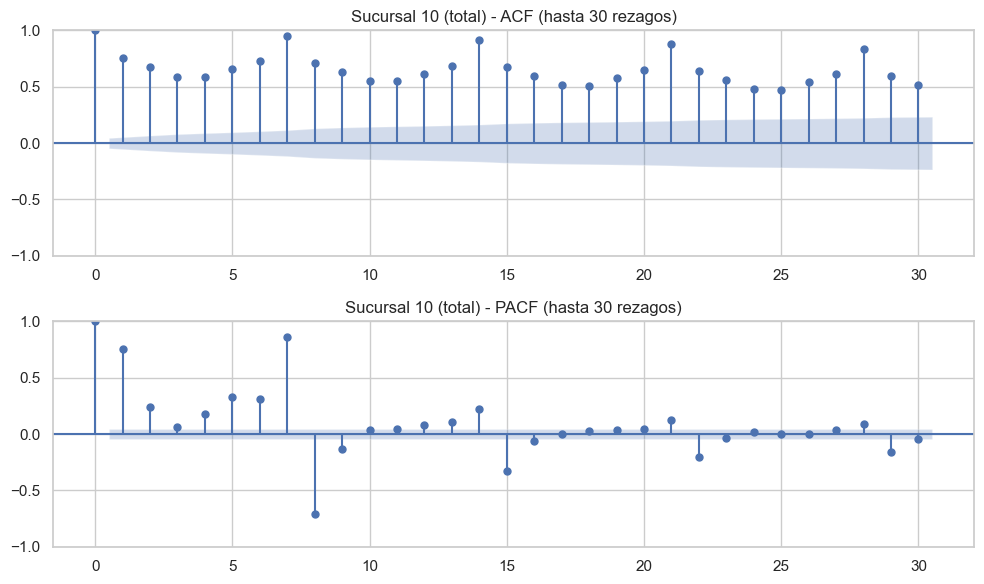

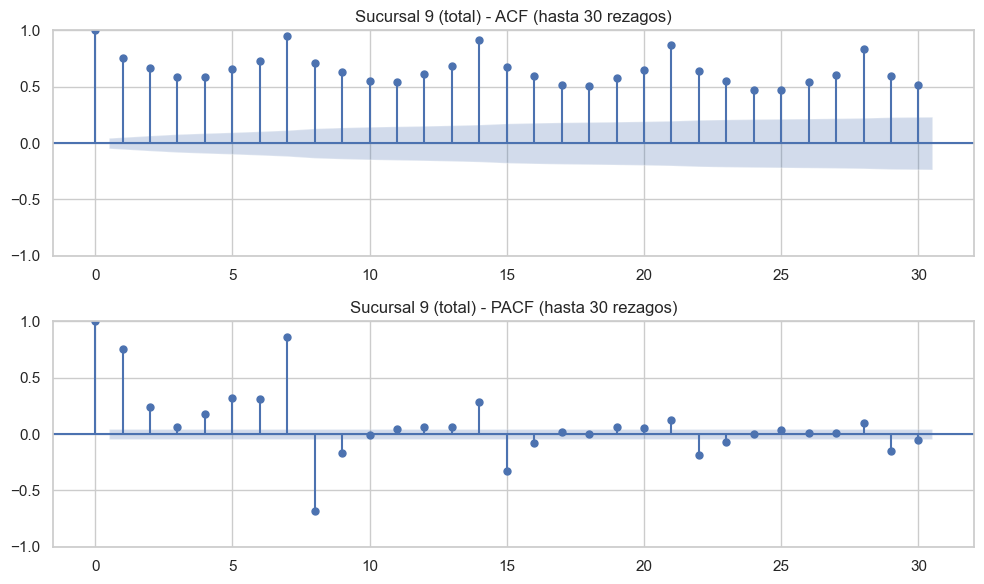

In [31]:
# b) Por sucursal (top S)
S = min(5, len(top_stores))  # ajusta S según tu necesidad
for s in top_stores.head(S).index:
    serie = df[df["store"] == s].groupby("date")["sales"].sum().sort_index()
    plot_acf_pacf(serie, lags=30, title_prefix=f"Sucursal {s} (total)")

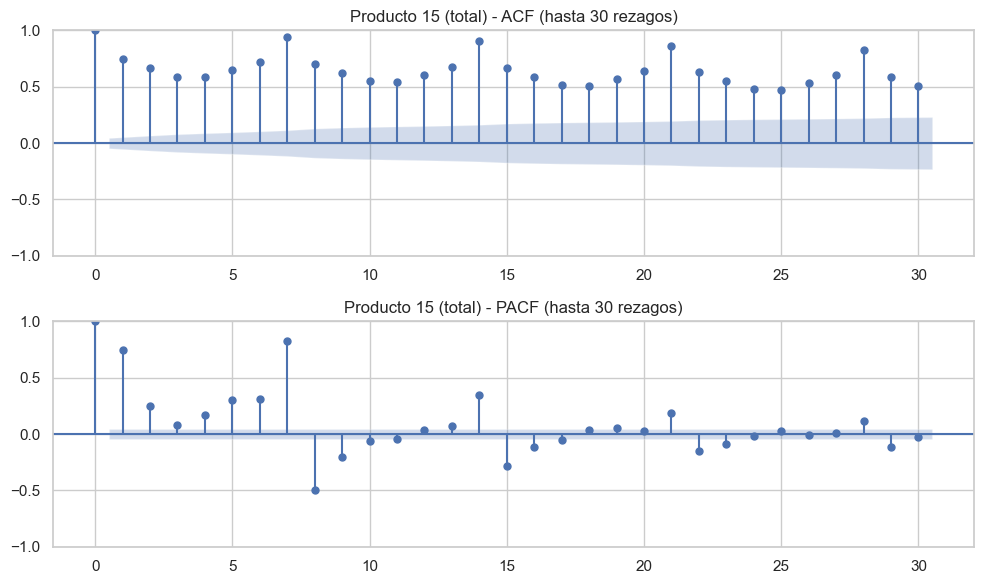

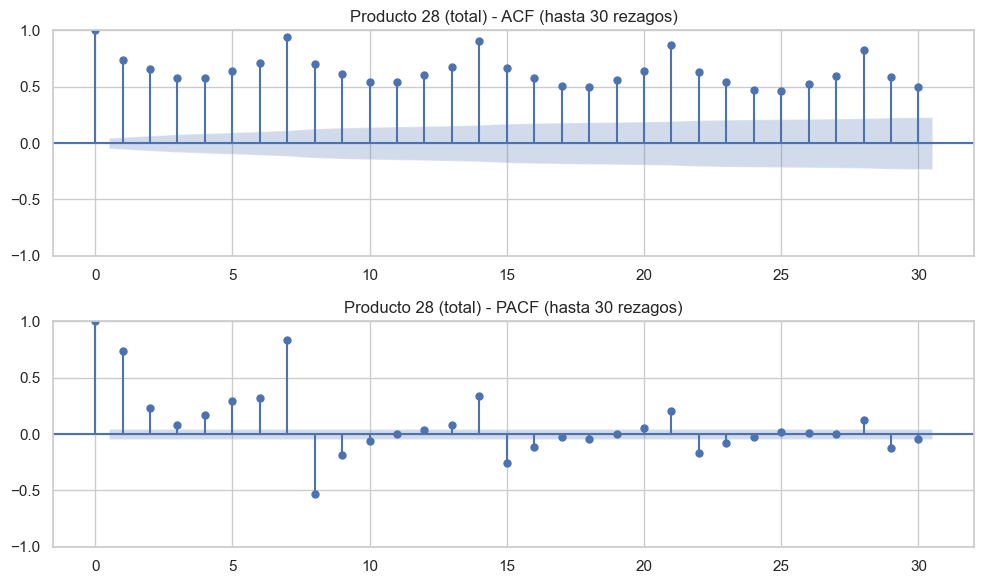

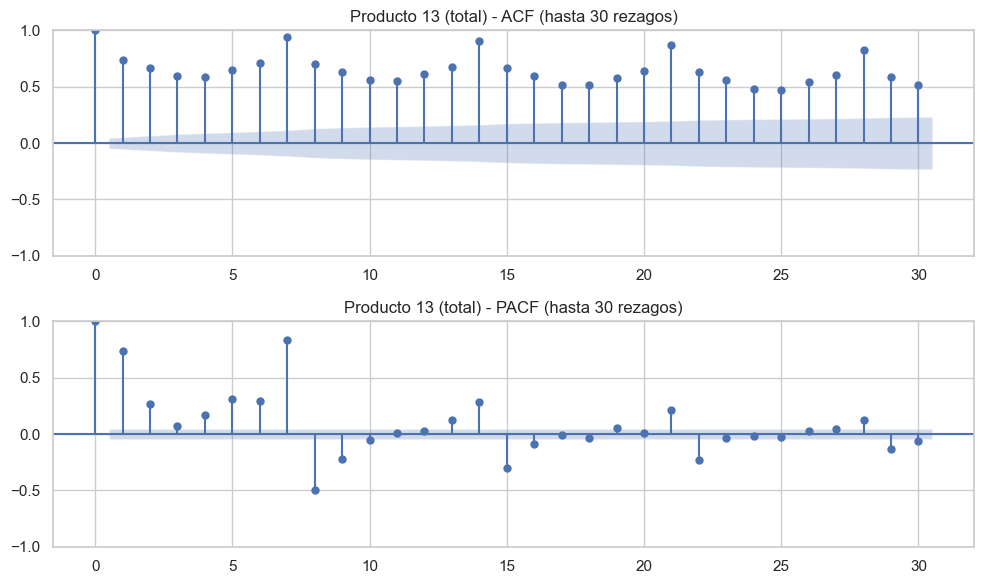

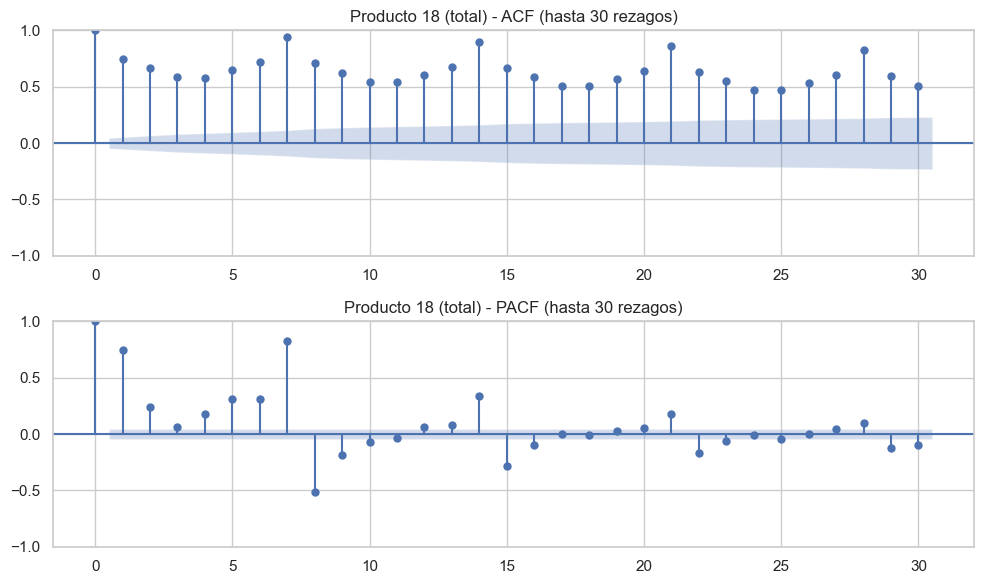

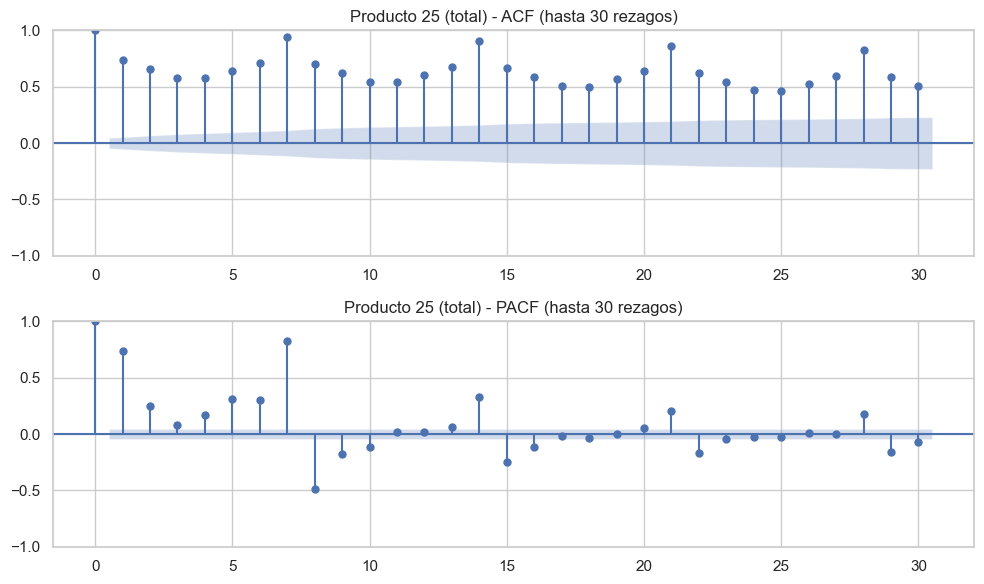

In [32]:
# c) Por producto (top P)
P = min(5, len(top_items))  # ajusta P
for it in top_items.head(P).index:
    serie = df[df["item"] == it].groupby("date")["sales"].sum().sort_index()
    plot_acf_pacf(serie, lags=30, title_prefix=f"Producto {it} (total)")

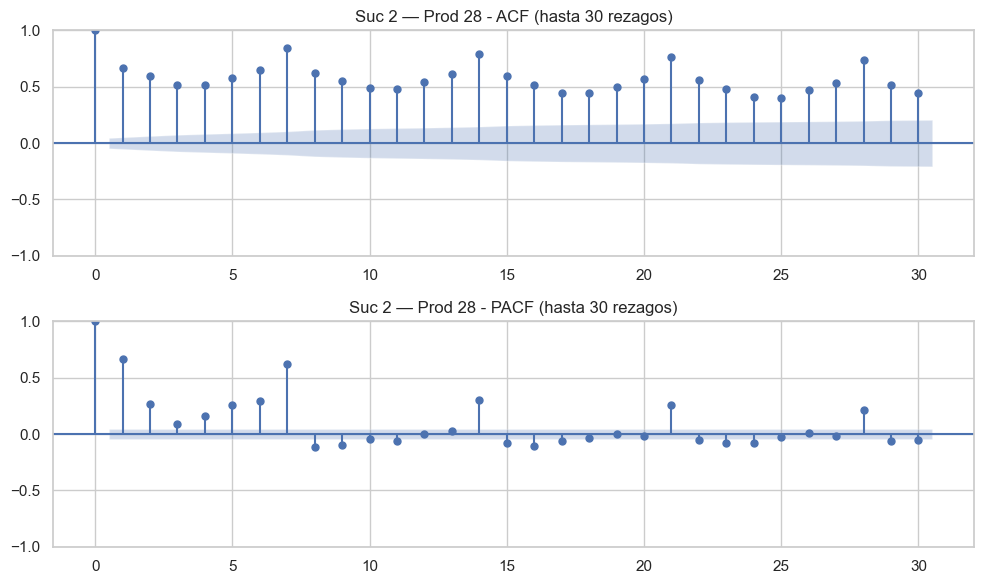

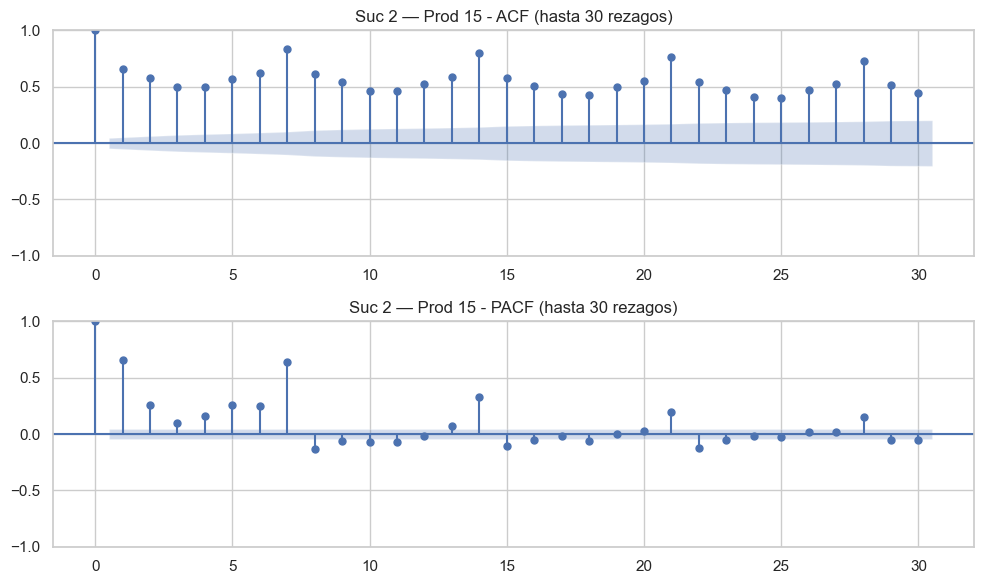

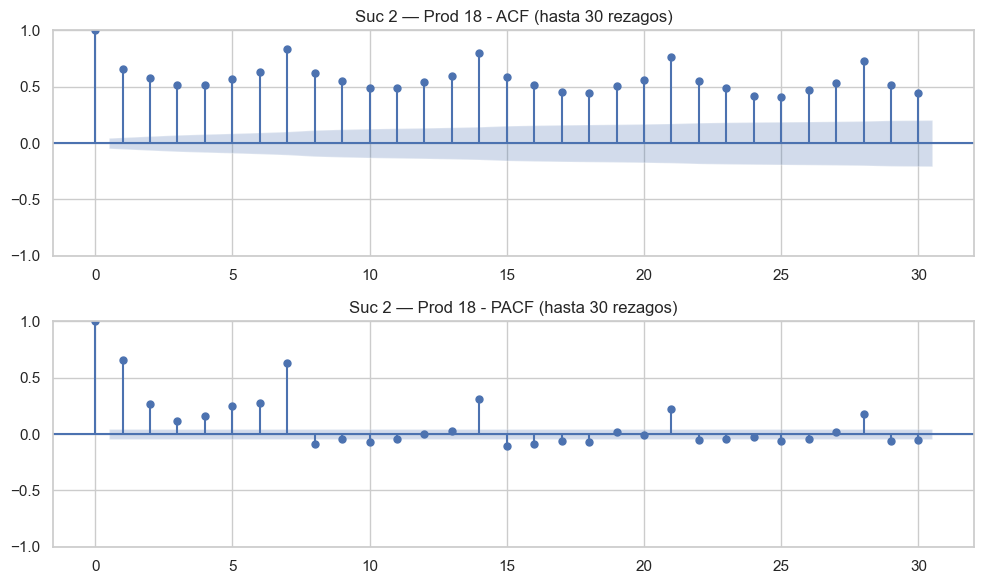

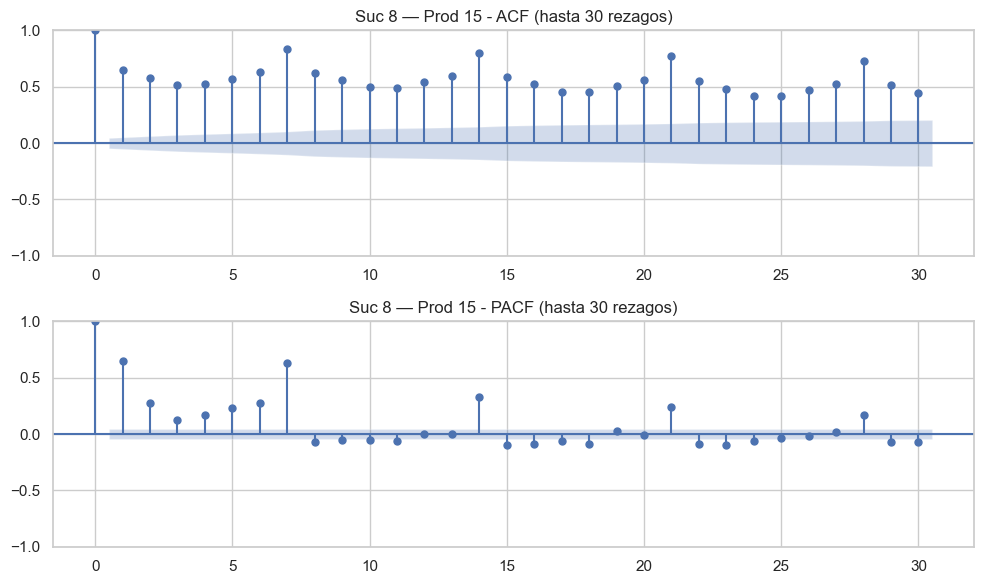

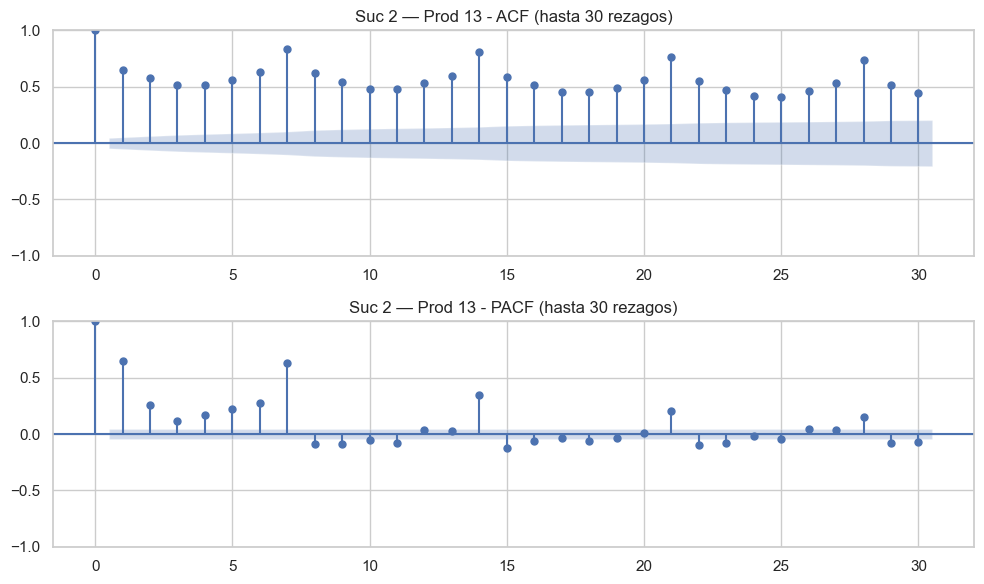

In [33]:
# d) Por (sucursal, producto) — elegir combinaciones top K por ventas totales para no saturar
pair_totals = df.groupby(["store","item"])["sales"].sum().sort_values(ascending=False)
K = min(5, len(pair_totals))
for (s, it), _ in pair_totals.head(K).items():
    serie = (df[(df["store"]==s) & (df["item"]==it)]
             .groupby("date")["sales"].sum().sort_index())
    plot_acf_pacf(serie, lags=30, title_prefix=f"Suc {s} — Prod {it}")


## Paso 10 — Insights y conclusiones


In [34]:
# Efecto día de la semana
dow_stats = df.groupby("dow_name")["sales"].agg(["mean","median","std","count"])
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dow_stats = dow_stats.reindex(dow_order)
# Efecto mensual
month_stats = df.groupby("month_name")["sales"].agg(["mean","median","std","count"])
month_order = [m for m in pd.date_range("2000-01-01","2000-12-01",freq="MS").month_name()]
month_stats = month_stats.reindex(month_order)
# Top contribuyentes
top_store = sales_by_store["sum"].idxmax()
top_item_ = sales_by_item["sum"].idxmax()

In [35]:
print("Ventas promedio por día de la semana (0=Lun ... 6=Dom):")
display(dow_stats)

print("Ventas promedio por mes:")
display(month_stats)

print(f"\nMayor contribución por sucursal: {top_store} (total={sales_by_store['sum'].max():,.0f})")
print(f"Mayor contribución por producto: {top_item_} (total={sales_by_item['sum'].max():,.0f})")

# Señales de estacionalidad básica
dow_range = dow_stats["mean"].max() - dow_stats["mean"].min()
month_range = month_stats["mean"].max() - month_stats["mean"].min()

print("\nIndicadores de patrón temporal (heurísticos):")
print(f"- Amplitud entre días de semana (promedios): {dow_range:,.2f}")
print(f"- Amplitud entre meses (promedios): {month_range:,.2f}")
print("- Si estas amplitudes son altas respecto a la media global, sugiere estacionalidad por día de semana/mes.")

# Calidad del dataset (nulos/duplicados ya reportados). Señal de huecos en series:
series_gaps = freq_checks["missing_days"].sum()
print("\nCalidad y preparación:")
print(f"- Total de días faltantes en todas las series (store-item): {int(series_gaps)}")
print("- Si > 0, considerar imputación (por ejemplo, forward-fill a nivel (store,item) o imputación con 0 según negocio).")


Ventas promedio por día de la semana (0=Lun ... 6=Dom):


,mean,median,std,count
dow_name,,,,
Monday,41.43,38.00,22.26,130000
Tuesday,48.23,44.00,25.77,130500
Wednesday,48.37,44.00,25.84,130500
Thursday,51.72,47.00,27.62,130500
Friday,55.16,50.00,29.40,130500
Saturday,58.66,53.00,31.14,130500
Sunday,62.14,57.00,32.94,130500


Ventas promedio por mes:


,mean,median,std,count
month_name,,,,
January,35.52,33.00,18.51,77500
February,39.38,36.00,20.44,70500
March,47.31,44.00,24.27,77500
April,55.15,51.00,28.30,75000
May,59.13,55.00,30.10,77500
June,63.03,58.00,32.03,75000
July,67.00,62.00,34.13,77500
August,59.11,55.00,30.08,77500
September,55.07,51.00,28.17,75000



Mayor contribución por sucursal: 2 (total=6,120,128)
Mayor contribución por producto: 15 (total=1,607,442)

Indicadores de patrón temporal (heurísticos):
- Amplitud entre días de semana (promedios): 20.71
- Amplitud entre meses (promedios): 31.47
- Si estas amplitudes son altas respecto a la media global, sugiere estacionalidad por día de semana/mes.

Calidad y preparación:
- Total de días faltantes en todas las series (store-item): 0
- Si > 0, considerar imputación (por ejemplo, forward-fill a nivel (store,item) o imputación con 0 según negocio).


### a) Variables que afectan directamente las ventas

* **Calendario (día de la semana):** patrón creciente de lunes a domingo; el domingo presenta el mayor promedio de ventas. Este efecto semanal es consistente a lo largo de los años.
* **Calendario (mes del año):** mínimos en enero–febrero y máximos en junio–agosto (pico en julio). Estacionalidad anual pronunciada.
* **Tendencia global:** crecimiento de la serie total a lo largo del tiempo.
* **Entidad comercial:**

  * **Sucursal:** diferencias estructurales y persistentes; la sucursal 2 es la de mayor contribución, seguida de la 8.
  * **Producto:** heterogeneidad entre ítems; el producto 15 lidera en volumen.
* **Efectos de rezago:** la ACF muestra picos en múltiplos de 7 días, reforzando la influencia de la semana previa y de semanas anteriores (7, 14, 21, 28).

**Variables recomendadas para el modelado**

* Dummies/embeddings de **día de la semana** y **mes**.
* **Lags**: 1, 7, 14, 28 (y móviles/medias si aplica).
* **Tendencia** (por ejemplo, contador de días) y, si se dispone, **festivos/eventos** locales.
* Identificadores de **store** e **item** o modelado por serie `(store,item)`.

---

### b) Patrones útiles para el modelo de forecasting

* **Estacionalidad semanal** muy marcada (ACF en 7, 14, 21, 28) y **estacionalidad anual** visible en heatmaps y promedios mensuales.
* **Sincronía estacional** entre entidades: los picos/valleys mensuales se repiten en prácticamente todas las sucursales y productos ⇒ señales comunes que el modelo puede capturar.
* **Heterogeneidad de nivel** entre sucursales y productos, estable en el tiempo ⇒ conviene modelar por serie o por clústeres de series con escalas similares.
* **Recomendaciones de modelado:**

  * Benchmarks: **Naive estacional (s=7)** y **Exponential Smoothing/ETS** con componente semanal.
  * **SARIMA** con `s=7` y, si se utiliza, diferencia estacional semanal; considerar intervención/ajuste de tendencia si se busca estacionariedad.
  * **Prophet** o modelos ML (XGBoost/LightGBM) con lags y variables calendario; para ML, normalizar/standardizar por serie o incluir “store/item effects”.
  * Validación temporal con ventanas rodantes y métricas robustas (MASE, sMAPE).

---

### c) Calidad y preparación del dataset para las siguientes etapas

* **Frecuencia y cobertura:** series diarias consistentes, sin días faltantes por `(store,item)`.
* **Integridad:** no se detectan problemas relevantes tras remover duplicados; tipos numéricos y fechas correctos.
* **Preprocesamiento recomendado:**

  * Garantizar frecuencia diaria por serie (resample si hiciera falta en nuevos datos).
  * Generar **features de calendario** y **lags** indicados.
  * Revisar y, de ser necesario, **capar/outliers** puntuales por `(store,item)` (IQR) para evitar sesgos.
  * Considerar **re-escalado por serie** (p. ej., z-score o Box-Cox si la varianza crece con el nivel).
  * Incorporar **calendarios de festivos/eventos** para explicar picos de mitad de año.
* **Listo para modelar:** con las transformaciones anteriores, el dataset está preparado para entrenar modelos con estacionalidad semanal y anual, y capturar la heterogeneidad por entidad.
